## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

#1.Załadowanie, wyczyszczenie i dystrybucja danych

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', delimiter=',', encoding='latin-1', names=['class', 'id2', 'log', 'x', 'nick', 'text'])
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

df.head(5)


Mounted at /content/drive
There are 1600000 rows and 6 columns


,class,id2,log,x,nick,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
#Czyszczenie danych
df.drop_duplicates()
df.dropna(subset=['text'], inplace=True)

nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

df.drop(['id2','log','x','nick'],axis=1,inplace=True)
df.head()



There are 1600000 rows and 6 columns


,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


array([[<Axes: title={'center': 'class'}>]], dtype=object)

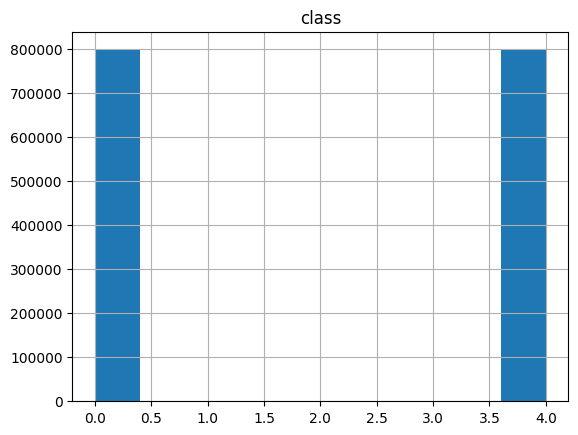

In [4]:
#Dystrybucja klas
df.hist(column="class")

In [5]:
#^ 0 - negatywna, 4 - pozytywna ^

#Rnn

#Cnn

In [6]:
y=df['class']
from sklearn.model_selection import train_test_split
df_train,df_test,y_train,y_test=train_test_split(df['text'],y,test_size=0.33,random_state=42)
print('DF Train Shape: ',df_train.shape)
print('DF Test Shape: ',df_test.shape)
print('Y Train Shape: ',y_train.shape)
print('Y Test Shape: ',y_test.shape)

DF Train Shape:  (1072000,)
DF Test Shape:  (528000,)
Y Train Shape:  (1072000,)
Y Test Shape:  (528000,)


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(df_train)
sequence_train=tokenizer.texts_to_sequences(df_train)
sequence_test=tokenizer.texts_to_sequences(df_test)

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(1072000, 116)

In [9]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(528000, 116)

In [10]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model

word2vec=tokenizer.word_index
V=len(word2vec)

D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
model=Model(i,x)
model.summary()

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=2,batch_size=100)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 116)]             0         
                                                                 
 embedding (Embedding)       (None, 116, 20)           10549420  
                                                                 
 conv1d (Conv1D)             (None, 114, 32)           1952      
                                                                 
 max_pooling1d (MaxPooling1  (None, 38, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                        

In [11]:
y_pred=model.predict(data_test)
y_pred

16500/16500 [==============================] - 26s 2ms/step


array([[5.79120278e-01, 2.31873372e-07, 2.37606741e-07, 2.32385219e-07,
        4.20879006e-01],
       [6.05093002e-01, 2.87994614e-18, 3.47909064e-18, 2.18736519e-18,
        3.94907027e-01],
       [3.26962531e-01, 1.60999061e-19, 3.84089220e-19, 8.48408717e-20,
        6.73037410e-01],
       ...,
       [3.75775024e-02, 2.04723210e-24, 2.31146145e-24, 8.71830337e-25,
        9.62422490e-01],
       [7.29649425e-01, 1.35068125e-20, 1.39127255e-20, 1.17568328e-20,
        2.70350605e-01],
       [4.49706912e-01, 1.18922014e-25, 9.84056894e-26, 5.10132651e-26,
        5.50293088e-01]], dtype=float32)

In [12]:
y_pred=np.argmax(y_pred,axis=1)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82    263321
           4       0.82      0.82      0.82    264679

    accuracy                           0.82    528000
   macro avg       0.82      0.82      0.82    528000
weighted avg       0.82      0.82      0.82    528000

